<a href="https://colab.research.google.com/github/Ogunfool/Timeseries-Data-Analysis-and-Forecasting/blob/main/ANN_for_Human_activity_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Data Classification with ANN.

1.   Take note of the data preparation or how the data is formatted for the ANN.
2.   Note the way the model is built - Multi-input ANN Model.





1.   Examine and analyse data. (Plot distributions from one instance to another), check for trends in and out-of-periods, seasonality??
2.   Prepare data - Differencing, AR-data, use PACF to decide the order to tune around

1.   Follow tensorflow workflow to build model 
2.   Prediction/forecast functions


1.   Model evaluation functions and plots
2.   Model selection/hyperparameter tuning

1.   Build reusable pipelines - Microsoft Azure (The ANN model building and compilation can be automated but the data preparation and input pipeline is different for different time series data types and problems (Classification, Regresion or Forecasting).
2. Save final model and make predictions.









Import Necessary Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import math
import datetime
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [ ]:
!wget https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones

In [ ]:
!wget https://lazyprogrammer.me/course_files/timeseries/UCI-HAR.zip

--2023-04-04 14:16:30--  https://lazyprogrammer.me/course_files/timeseries/UCI-HAR.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60999314 (58M) [application/zip]
Saving to: ‘UCI-HAR.zip’

UCI-HAR.zip         100%[===================>]  58.17M  26.2MB/s    in 2.2s    

2023-04-04 14:16:33 (26.2 MB/s) - ‘UCI-HAR.zip’ saved [60999314/60999314]



Load data - Data is 3-dimensional.

In [ ]:
!unzip /content/UCI-HAR.zip

In [ ]:
!unzip -nq UCI-HAR.zip

In [ ]:
!ls

 Human+Activity+Recognition+Using+Smartphones   sample_data	   UCI-HAR.zip
 __MACOSX				       'UCI HAR Dataset'


In [ ]:
!ls 'UCI HAR Dataset'

activity_labels.txt  features_info.txt	features.txt  README.txt  test	train


In [ ]:
!ls 'UCI HAR Dataset/train'

'Inertial Signals'   subject_train.txt	 X_train.txt   y_train.txt


In [ ]:
!head 'UCI HAR Dataset/train/X_train.txt'

In [ ]:
# Load data with numpy
hum_train = pd.read_csv('/content/UCI HAR Dataset/train/Inertial Signals/body_acc_x_train.txt', header=None, 
                     delim_whitespace=True)
hum_train.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.000181,0.010139,0.009276,0.005066,0.010810,0.004045,0.004757,0.006214,0.003307,0.007572,...,0.001412,-0.001509,0.000060,0.000435,-0.000819,0.000228,-0.000300,-0.001147,-0.000222,0.001576
1,0.001094,0.004550,0.002879,0.002247,0.003305,0.002416,0.001619,0.000981,0.000009,-0.000363,...,-0.000104,-0.000141,0.001333,0.001541,0.001077,-0.000736,-0.003767,-0.004646,-0.002941,-0.001599
2,0.003531,0.002285,-0.000420,-0.003738,-0.006706,-0.003148,0.000733,0.000668,0.002162,-0.000946,...,0.000661,0.001853,-0.000268,-0.000394,-0.000279,-0.000316,0.000144,0.001246,0.003117,0.002178
3,-0.001772,-0.001311,0.000388,0.000408,-0.000355,0.000998,0.001109,-0.003149,-0.008882,-0.010483,...,0.000458,0.002103,0.001358,0.000820,-0.000212,-0.001915,-0.001631,-0.000867,-0.001172,-0.000028
4,0.000087,-0.000272,0.001022,0.003126,0.002284,0.000885,0.001933,0.002270,0.002247,0.002175,...,0.002529,0.003518,-0.000248,-0.002761,0.000252,0.003752,0.001626,-0.000698,-0.001223,-0.003328


In [ ]:
# NxT for a single feature
hum_train.shape

(7352, 128)

In [ ]:
hum_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 128 entries, 0 to 127
dtypes: float64(128)
memory usage: 7.2 MB


<Axes: >

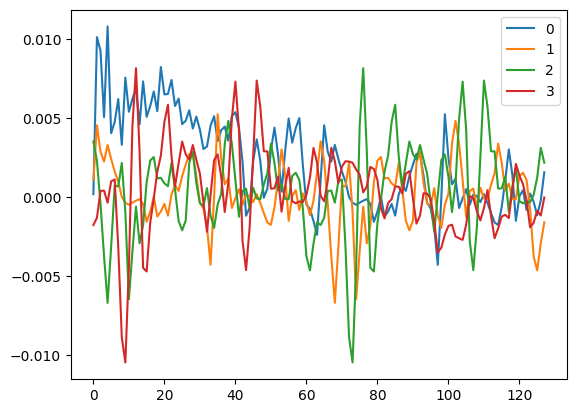

In [ ]:
hum_train.loc[:3].T.plot()

In [ ]:
hum_y = pd.read_csv('/content/UCI HAR Dataset/train/y_train.txt')
hum_y.head()

In [ ]:
hum_y.shape

(7351, 1)

In [ ]:
np.unique(hum_y)

array([1, 2, 3, 4, 5, 6])

Understanding the data and feature engineering: Depending on the domain knowledge, some features acn be extracted from the timeseries data; kurtosis, skewness, mean etc. They are commonly referred to as time domain or frequency domain features; see https://www.mathworks.com/help/predmaint/ug/wind-turbine-high-speed-bearing-prognosis.html
But they require some domain expertise/knowledge.

Prepare Your Data:Create an array of size NxTxD.
We don't need to create NxTxD first then list of NxT, we can just create a list of NxT directly.

In [ ]:
T = hum_train.shape[1]   # Sample duration
Ntrain = hum_train.shape[0]  # No of samples
D = 9  # No of features per smaple
K = np.unique(hum_y).shape[0]  # No of classes
Ntest = 2947
# print(T, Ntrain, D, K)

In [ ]:
T = 128
Ntrain = 7352
D = 9
K = 6
Ntest = 2947

In [ ]:
# Load Data, Form NxTxK array and/or list of inputs into the model.
def load_data():
  # Returns:
  # Xtrain (Ntrain x T x D), Ytrain (Ntrain)
  # Xtest (Ntest x T x D), Ytest (Ntest)
  # Model input list for train and test

  Xtrain = np.zeros((Ntrain, T, D))
  Xtest = np.zeros((Ntest, T, D))
  x_train = []
  x_test = []

  # train data
  ts_filenames = [
    'body_acc_x_train.txt', 'body_gyro_x_train.txt', 'total_acc_x_train.txt',
    'body_acc_y_train.txt', 'body_gyro_y_train.txt', 'total_acc_y_train.txt',
    'body_acc_z_train.txt', 'body_gyro_z_train.txt', 'total_acc_z_train.txt',
  ]

  ts_file_prefix = '/content/UCI HAR Dataset/train/'

  for d, fn in enumerate(ts_filenames):
    df = pd.read_csv(f'{ts_file_prefix}Inertial Signals/{fn}', header=None, delim_whitespace=True)

    # Ntrain x T array
    x = df.to_numpy()
    Xtrain[:, :, d] = x

    # list of arrays
    x_train.append(x)
  
  # train labels
  Ytrain = pd.read_csv(f'{ts_file_prefix}y_train.txt', header=None).to_numpy() - 1   #Classes change from 1-6 to 0-5
  Ytrain = Ytrain.flatten()

  # test data
  ts_filenames = [
    'body_acc_x_test.txt', 'body_gyro_x_test.txt', 'total_acc_x_test.txt',
    'body_acc_y_test.txt', 'body_gyro_y_test.txt', 'total_acc_y_test.txt',
    'body_acc_z_test.txt', 'body_gyro_z_test.txt', 'total_acc_z_test.txt',
  ]

  ts_file_prefix = '/content/UCI HAR Dataset/test/'

  for d, fn in enumerate(ts_filenames):
    df = pd.read_csv(f'{ts_file_prefix}Inertial Signals/{fn}', header=None, delim_whitespace=True)

    # Ntrain x T array
    x = df.to_numpy()
    Xtest[:, :, d] = x

    x_test.append(x)
  
  # test labels
  Ytest = pd.read_csv(f'{ts_file_prefix}y_test.txt', header=None).to_numpy() - 1
  Ytest = Ytest.flatten()

  return Xtrain, Ytrain, Xtest, Ytest, x_train, x_test

In [ ]:
Xtrain, Ytrain, Xtest, Ytest, x_train, x_test = load_data()

In [ ]:
print(Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape)
print(len(x_train), len(x_test))

(7352, 128, 9) (7352,) (2947, 128, 9) (2947,)
9 9


In [ ]:
x_train[0].shape

THE ANN Model using the keras functional API: Note the following;


1.   The functional API uses symbolic tensors that store evry operation performed on them after initialization.
2.   The model accepts the inputs and output arguments. The inputs can be a list and so is the output.



1.   Each input layer expects a shape (T,) nd the model expects a list of inputs of shape (T,). The point here is during prediction, for each feature, a (T,) shpe is required. So this model can be used for classification and regression not forecasting where the complete T, dataset is unknown. 

1.   Note how we pass the variables around just as we would when we create a function.


1.  You can plot your model. 













In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy, categorical_crossentropy, mean_squared_error
from tensorflow.keras.optimizers import Adam, RMSprop, Adagrad, SGD
from tensorflow.keras.metrics import Accuracy, Recall
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
# The ANN Model development - Multi-Input/Multi-tail ANN
# You have to keep track of the input and the output of the model
inputs = []
features = []

# Build a dense ANN model for each feature - 
# If you use the input layers in a for loop, different unique instances of the symbolic tensors are automatically created - So they can have their unique function flow
for _ in range(D):
  i = Input(shape=(T,))
  x = Dense(32, activation='relu')(i)
  x = Dense(32, activation='relu')(x)
  inputs.append(i)
  features.append(x)

# recall, we want to concatenate the outputs of the multi-unit ANN models
# N x (FxD)
x = Concatenate()(features)
# Now start working on this
x = Dense(K)(x)

# Instantiate Model
model = Model(inputs, x)

In [ ]:
features

[<KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'dense_1')>,
 <KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'dense_3')>,
 <KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'dense_5')>,
 <KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'dense_7')>,
 <KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'dense_9')>,
 <KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'dense_11')>,
 <KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'dense_13')>,
 <KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'dense_15')>,
 <KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'dense_17')>]

In [ ]:
model.summary()

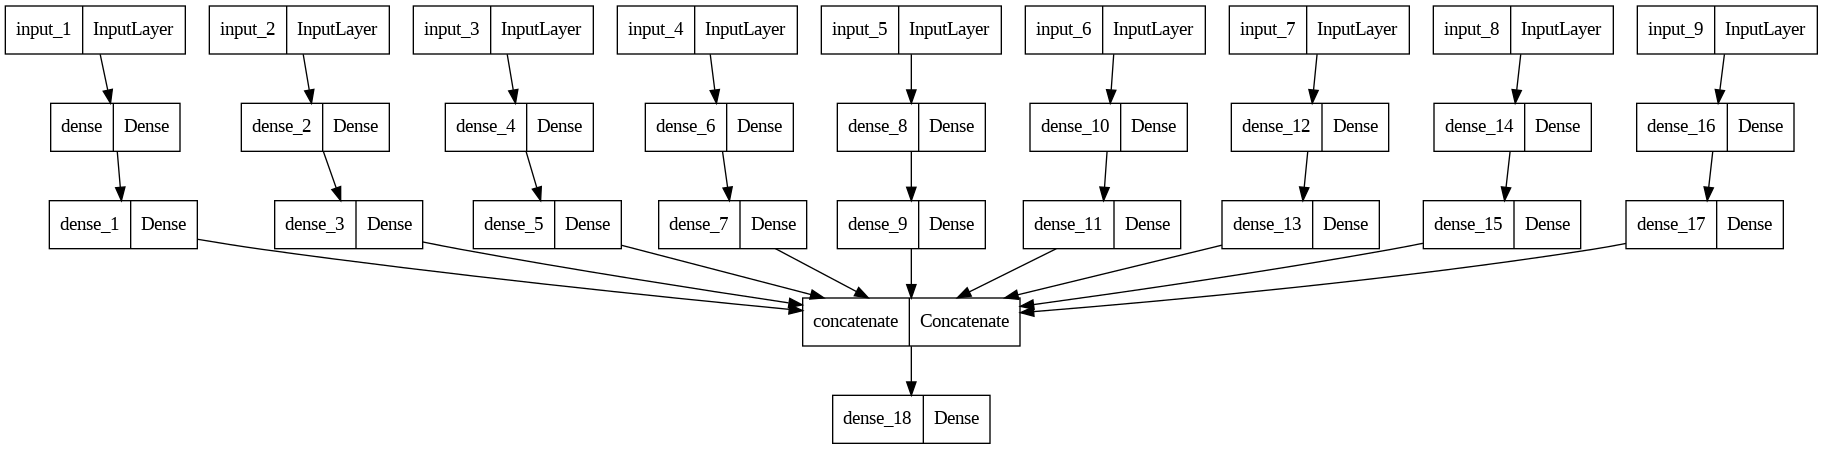

In [ ]:
tf.keras.utils.plot_model(model)

Let's try another method - The method is ok, but the above is more intuitive so I prefer it.

In [ ]:
# Build a dense ANN model for each feature - 
# If you use the input layers in a for loop, different unique instances of the symbolic tensors are automatically created - So they can have their unique function flow
for _ in range(D):
  i = Input(shape=(T,))
  x = Dense(32, activation='relu')(i)
  x = Dense(32, activation='relu')(x)
  inputs.append(i)
  features.append(x)

# Merge models rather than concatenate
merged = tf.keras.layers.add(features)

# define functional model
model = Model(inputs, merged)

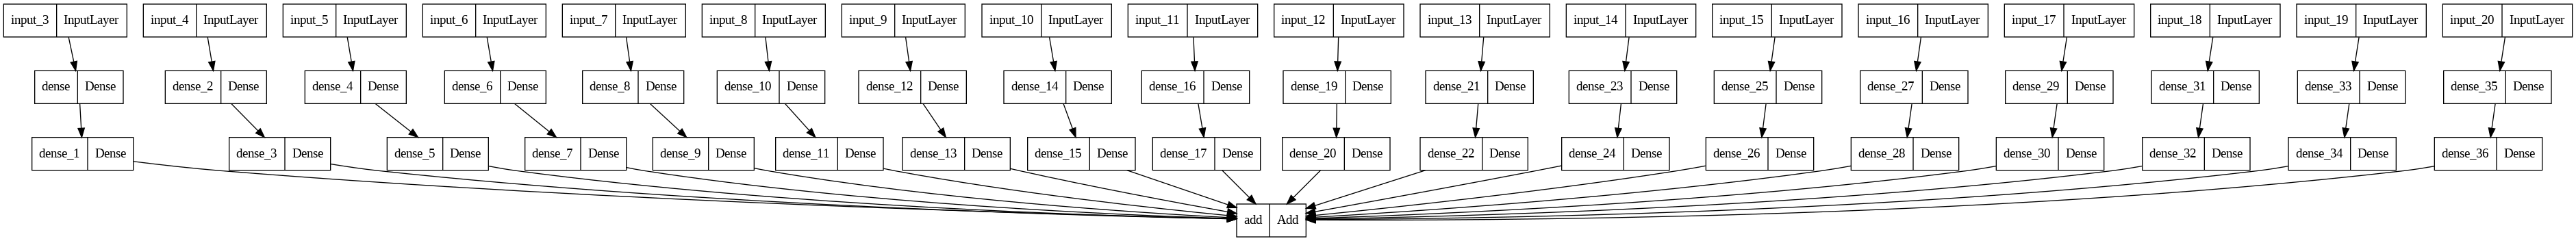

In [ ]:
tf.keras.utils.plot_model(model)

Compile, Fit, Predict and Evaluate Model.

Compile and callbacks helper function

In [ ]:
# Let's create some helper functions for the training process (We are trying to select a model so, many models will be trained and they have similar execution configurations)
# Learning Rate Scheduler:
def lr_scheduler(STEPS_PER_EPOCH):
  lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*1000,
    decay_rate=1,
    staircase=False)
  return lr_schedule

def get_optimizer(scheduler=None):
  if scheduler is None:
    return tf.keras.optimizers.Adam(learning_rate=0.001)
  return tf.keras.optimizers.Adam(lr_scheduler())

# def get_callbacks():
#   return [
#     tfdocs.modeling.EpochDots(),
#     tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=40),
#   ]

# Compile and fit
# You can pass in a different loss function and optimizer asides from the default adam and sparsecategorical loss I set:
def compile(model, optimizer=None, scheduler=None,  loss=None, max_epochs=1000, STEPS_PER_EPOCH=1000):
  if optimizer is None:    # that is, i want to set Adam optimizer & learning rate to 0.001 by default or use a lr_scheduler function
    optimizer = get_optimizer()
  else:
    optimizer = optimizer

  if loss is None:
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  else:
    loss = loss

  model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

  return model


In [ ]:
model = compile(model)
check_point = ModelCheckpoint(
    'best_model.h5', monitor='val_accuracy', save_best_only=True)
# model.summary()

history = model.fit(x_train, Ytrain, epochs=15, 
                    validation_data=(x_test, Ytest),
                    callbacks=[check_point],
                    verbose=2)


In [ ]:
# Evaluate on test set
model.evaluate(x_test, Ytest)

93/93 [==============================] - 0s 2ms/step - loss: 0.3822 - accuracy: 0.9223


[0.3821779489517212, 0.9222938418388367]

In [ ]:
# Load best model
best_model = tf.keras.models.load_model('best_model.h5')

# Make predictions with best model 
y_pred = best_model.predict(x_test)

# Evaluate with best model
best_model.evaluate(x_test, Ytest)

93/93 [==============================] - 1s 3ms/step - loss: 0.3101 - accuracy: 0.9260


[0.31013360619544983, 0.926026463508606]

Plots Helper Functions

In [ ]:
# Helper function that plots, saves and shows plots
def plot_loss_accuracy(filename):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend(loc=0)
  plt.figure()

  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation accuracy')
  plt.legend(loc=0)
  plt.figure()

  plt.savefig(filename + '.png')
  plt.show()

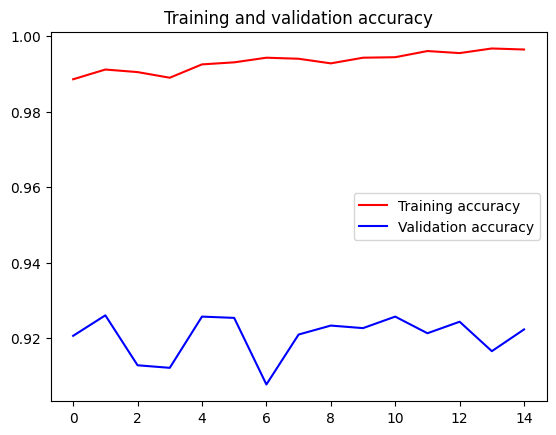

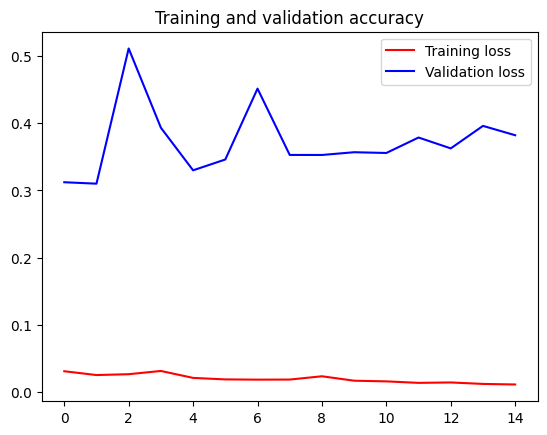

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_loss_accuracy(filename='ANN for timeseries classification')

Time and Frequency Domain Signals of the data.

In [ ]:
X_train = np.loadtxt('/content/UCI HAR Dataset/train/X_train.txt')

In [ ]:
X_train.shape

(7352, 561)

In [ ]:
X_train[0]

We can use this combined model to use the inertia data of shape NxTxD and time & frequency data with shape NxD together.

In [ ]:
# Combined Model
inputs = []
features = []

# make a neural network for each of the D time series
for d in range(D):
  i = Input(shape=(T,))
  x = Dense(32, activation='relu')(i)
  x = Dense(16, activation='relu')(x)
  inputs.append(i)
  features.append(x)

i2 = Input(shape=(561,))
x2 = Dense(32, activation='relu')(i2)

# output of concatenate will be D * (size of individual ANN output)
x = Concatenate()(features + [x2])
x = Dense(K)(x)
model = Model(inputs + [i2], x)

Finally, How about I just use N x (TxD) as input to a neural network?

In [ ]:
# Prepare Data - Use x_train list
Xtrain = x_train[0]
for id in np.arange(1,len(x_train)):
  Xtrain = np.concatenate((Xtrain, x_train[id]), axis=1)

Xtrain.shape


(7352, 1152)

In [ ]:
# Prepare Data - Use x_test list
Xtest = x_test[0]
for id in np.arange(1,len(x_test)):
  Xtest = np.concatenate((Xtest, x_test[id]), axis=1)

Xtest.shape

(2947, 1152)

In [ ]:
# Basic ANN
i = Input(shape=(1152,))
x = Dense(32, activation='relu')(i)
x = Dense(32, activation='relu')(x)
x = Dense(K)(x)
model = Model(i, x)

In [ ]:
model = compile(model)
check_point = ModelCheckpoint(
    'best_model.h6', monitor='val_accuracy', save_best_only=True)
# model.summary()

history = model.fit(Xtrain, Ytrain, epochs=15, 
                    validation_data=(Xtest, Ytest),
                    callbacks=[check_point],
                    verbose=2)


Epoch 1/15


230/230 - 2s - loss: 0.6964 - accuracy: 0.7635 - val_loss: 0.5907 - val_accuracy: 0.8093 - 2s/epoch - 10ms/step
Epoch 2/15


230/230 - 1s - loss: 0.2760 - accuracy: 0.9056 - val_loss: 0.4559 - val_accuracy: 0.8446 - 1s/epoch - 6ms/step
Epoch 3/15


230/230 - 1s - loss: 0.1863 - accuracy: 0.9304 - val_loss: 0.5012 - val_accuracy: 0.8565 - 1s/epoch - 6ms/step
Epoch 4/15


230/230 - 1s - loss: 0.1521 - accuracy: 0.9416 - val_loss: 0.5027 - val_accuracy: 0.8778 - 1s/epoch - 6ms/step
Epoch 5/15


230/230 - 2s - loss: 0.1261 - accuracy: 0.9479 - val_loss: 0.5297 - val_accuracy: 0.8836 - 2s/epoch - 9ms/step
Epoch 6/15
230/230 - 1s - loss: 0.1112 - accuracy: 0.9546 - val_loss: 0.6204 - val_accuracy: 0.8585 - 956ms/epoch - 4ms/step
Epoch 7/15
230/230 - 1s - loss: 0.1024 - accuracy: 0.9581 - val_loss: 0.6860 - val_accuracy: 0.8571 - 667ms/epoch - 3ms/step
Epoch 8/15
230/230 - 1s - loss: 0.1005 - accuracy: 0.9582 - val_loss: 0.6800 - val_accuracy: 0.8629 - 629ms/epoch - 3ms/step
Epoch 9/15
230/230 - 1s - loss: 0.0917 - accuracy: 0.9612 - val_loss: 0.7092 - val_accuracy: 0.8571 - 621ms/epoch - 3ms/step
Epoch 10/15
230/230 - 1s - loss: 0.0935 - accuracy: 0.9589 - val_loss: 0.7882 - val_accuracy: 0.8575 - 644ms/epoch - 3ms/step
Epoch 11/15
230/230 - 1s - loss: 0.0887 - accuracy: 0.9614 - val_loss: 0.7587 - val_accuracy: 0.8639 - 635ms/epoch - 3ms/step
Epoch 12/15
230/230 - 1s - loss: 0.0843 - accuracy: 0.9629 - val_loss: 0.9042 - val_accuracy: 0.8490 - 608ms/epoch - 3ms/step
Epoch 13/15

In [ ]:
# Evaluate on test set
model.evaluate(Xtest, Ytest)

93/93 [==============================] - 0s 3ms/step - loss: 1.0596 - accuracy: 0.8514


[1.0596213340759277, 0.8513742685317993]

In [ ]:
# Load best model
best_model = tf.keras.models.load_model('best_model.h6')

# Make predictions with best model 
y_pred = best_model.predict(Xtest)

# Evaluate with best model
best_model.evaluate(Xtest, Ytest)

93/93 [==============================] - 0s 2ms/step - loss: 0.5297 - accuracy: 0.8836


[0.5296804308891296, 0.8836104273796082]

Comment: We can see that the accuracy with this method is much lower. It will require more training and tuning to achieve accuracy close to that of the initial model. Now you see why that initial method is key.